In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [170]:
pd.set_option('display.max_columns', None)

In [171]:
df = pd.read_csv('academic_train.csv',header=0,index_col=0)
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,5,5,122.6,0,0,0,1,0,1,18,0,0,6,6,6,14.500000,0,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,9,9,119.8,1,0,0,1,0,0,18,0,0,6,8,4,11.600000,0,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,2,3,144.7,0,0,0,1,1,0,18,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,3,2,126.1,1,0,0,1,0,1,18,0,0,7,9,7,12.591250,0,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,4,9,120.1,1,0,0,1,0,0,18,0,0,7,12,6,12.933333,0,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [172]:
print(df.shape)
print(df.isna().sum().sum())

(76518, 37)
0


In [173]:
x,y = df.iloc[:,:df.shape[1]-1],df.iloc[:,-1]

In [174]:
make_dummy_cols = [1,2,3,7,8,9,10,11]
standardize_cols = [6,12,19,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
make_dummy_cols = [df.columns[i] for i in make_dummy_cols]
standardize_cols = [df.columns[i] for i in standardize_cols]

In [175]:
x[standardize_cols] = StandardScaler().fit_transform(x[standardize_cols])

for column in make_dummy_cols:
    dummies = pd.get_dummies(x[column], prefix=column, drop_first=False, dtype=int)
    x = x.drop(column, axis=1)
    for col in dummies.columns:
        x[col] = dummies[col]

C:\Users\Alessio\AppData\Local\Temp\ipykernel_4460\1552330005.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x[col] = dummies[col]
C:\Users\Alessio\AppData\Local\Temp\ipykernel_4460\1552330005.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x[col] = dummies[col]
C:\Users\Alessio\AppData\Local\Temp\ipykernel_4460\1552330005.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

In [176]:
y = LabelEncoder().fit_transform(y)  # encode target categorical variable

In [177]:
x.shape

(76518, 265)

In [178]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [179]:
class TabularDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)  # Use long for classification

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [180]:
train_dataset = TabularDataset(x_train, y_train)
test_dataset = TabularDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [181]:
class MultiClassNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiClassNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [182]:
model = MultiClassNN(input_size=x_train.shape[1], num_classes=len(np.unique(y_train)))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

Epoch [1/20], Loss: 0.4994
Epoch [2/20], Loss: 0.4597
Epoch [3/20], Loss: 0.4519
Epoch [4/20], Loss: 0.4456
Epoch [5/20], Loss: 0.4404
Epoch [6/20], Loss: 0.4347
Epoch [7/20], Loss: 0.4292
Epoch [8/20], Loss: 0.4234
Epoch [9/20], Loss: 0.4168
Epoch [10/20], Loss: 0.4100
Epoch [11/20], Loss: 0.4044
Epoch [12/20], Loss: 0.3976
Epoch [13/20], Loss: 0.3917
Epoch [14/20], Loss: 0.3845
Epoch [15/20], Loss: 0.3770
Epoch [16/20], Loss: 0.3688
Epoch [17/20], Loss: 0.3624
Epoch [18/20], Loss: 0.3551
Epoch [19/20], Loss: 0.3455
Epoch [20/20], Loss: 0.3390


Accuracy of the model: 81.19%
0.916141458956676
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      5084
           1       0.62      0.56      0.59      3056
           2       0.84      0.91      0.87      7164

    accuracy                           0.81     15304
   macro avg       0.78      0.77      0.77     15304
weighted avg       0.81      0.81      0.81     15304



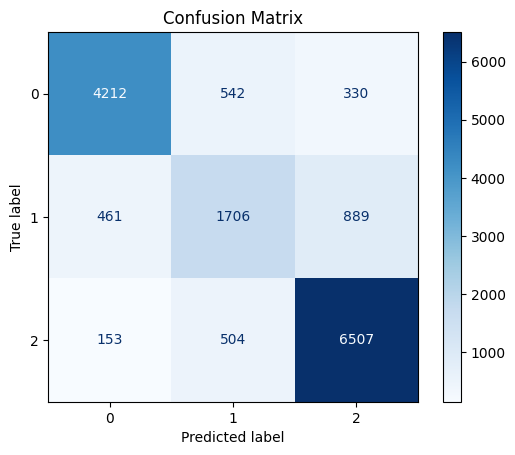

In [183]:
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
all_probabilities = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        probabilities = torch.softmax(outputs, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())
        all_probabilities.extend(probabilities.numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

cm = confusion_matrix(all_labels, all_predictions)

print(f'Accuracy of the model: {100 * correct / total:.2f}%')
print(roc_auc_score(all_labels, all_probabilities, multi_class='ovr'))
print(classification_report(all_labels, all_predictions))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [184]:
torch.save(model.state_dict(), 'academic_success.pth')